# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import zstandard as zstd
from zstandard import ZstdDecompressor

import json
import pickle

import re
import string
import datetime
import unicodedata
import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package punkt to
[nltk_data]     /home/msds2022/smendoza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2022/smendoza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Defining Functions

## Data Extraction 

### Reddit *.zst to pickle

The function below accepts a parameter to specify that subreddit that will be extracted and a list of compressed files that contains the reddit data. The function will decompress these files by chunk to avoid Dead Kernels.

In [2]:
def extract_reddit(fname, subreddit):
    """Return list of Json objects from Reddit filename

    Thanks to Prof Leo for code snippetse on the extraction 
    of chunk of bytes at a time. This function can extract 
    from compression .zst only.

    Input
    -----
    fname: filename
        String
    subreddit: subreddit label
        String

    Result
    ------
    list of json objects from reddit submissions for specified filename
        having the subreddit key equal to input subreddit
    """

    # Static filepath for source of Reddit Data
    path = '/mnt/data/public/reddit/submissions/'
    fp = path + fname
    print('* Processing:', fp)

    json_extracted = []
    with open(fp, "rb") as fh:
        dctx = zstd.ZstdDecompressor()
        print('>>Starting', end='')
        with dctx.stream_reader(fh) as reader:
            previous_line = ""
            while True:
                chunk = reader.read(2**24)
                if not chunk:
                    break
                string_data = chunk.decode('utf-8')
                lines = string_data.split("\n")
                for i, line in enumerate(lines[:-1]):
                    if i == 0:
                        line = previous_line+line
                    text = json.loads(line)
                    text_sub = str.lower(text['subreddit'])
                    # Only extract posts that are for specified subreddit
                    if text_sub == subreddit:
                        json_extracted.append(text)
                previous_line = lines[-1]

    print('Completed')
    return json_extracted

List of all the Reddit files to be extracted

In [3]:
fp_list = [
    'RS_2019-01.zst', 'RS_2019-02.zst', 'RS_2019-03.zst', 'RS_2019-04.zst',
    'RS_2019-05.zst', 'RS_2019-06.zst', 'RS_2019-07.zst', 'RS_2019-08.zst',
    'RS_2019-09.zst', 'RS_2019-10.zst', 'RS_2019-11.zst', 'RS_2019-12.zst',
    'RS_2020-01.zst', 'RS_2020-02.zst', 'RS_2020-03.zst', 'RS_2020-04.zst'
]

For each of the reddit files, create separate pickle files that contain dictionary object having
* key = filename without extension
* item = list of json objects meeting having specified subreddit topic

Write pickle files in subfolder ```/data_preprocessed``` with filename ```RS_YYYY-MM.pkl```

In [4]:
# Modify to True if you want to run the extraction again
# BE CAREFUL!
overwrite = False

# Extraction proper
if overwrite == True:
    for fname in fp_list:

        # create new dictionary per file
        json_all = dict()

        # subreddit of interest is 'philippines'
        x = extract_reddit(fname, 'philippines')

        fname_date = fname.split('.')[0]
        json_all[fname_date] = x
        #for each source file, print number of json objects extracted
        print(f"File: {fname_date} >> {len(x)}")

    # Once all files are extracted as json objects
    # Write into a pickle file
        fp_dir = "./data_preprocessed/reddit"
        with open(f"{fp_dir}_{fname_date}.pkl","wb") as file:
            pickle.dump(json_all, file)

**Log of extraction with accompanying count of json objects saved**

* Processing: /mnt/data/public/reddit/submissions/RS_2019-01.zst
>StartingCompleted
File: RS_2019-01 >> 7131
* Processing: /mnt/data/public/reddit/submissions/RS_2019-02.zst
>StartingCompleted
File: RS_2019-02 >> 7106
* Processing: /mnt/data/public/reddit/submissions/RS_2019-03.zst
>StartingCompleted
File: RS_2019-03 >> 7731
* Processing: /mnt/data/public/reddit/submissions/RS_2019-04.zst
>StartingCompleted
File: RS_2019-04 >> 7091
* Processing: /mnt/data/public/reddit/submissions/RS_2019-05.zst
>StartingCompleted
File: RS_2019-05 >> 8515
* Processing: /mnt/data/public/reddit/submissions/RS_2019-06.zst
>StartingCompleted
File: RS_2019-06 >> 6903
* Processing: /mnt/data/public/reddit/submissions/RS_2019-07.zst
>StartingCompleted
File: RS_2019-07 >> 7285
* Processing: /mnt/data/public/reddit/submissions/RS_2019-08.zst
>StartingCompleted
File: RS_2019-08 >> 6945
* Processing: /mnt/data/public/reddit/submissions/RS_2019-09.zst
>StartingCompleted
File: RS_2019-09 >> 6852
* Processing: /mnt/data/public/reddit/submissions/RS_2019-10.zst
>StartingCompleted
File: RS_2019-10 >> 6791
* Processing: /mnt/data/public/reddit/submissions/RS_2019-11.zst
>StartingCompleted
File: RS_2019-11 >> 6510
* Processing: /mnt/data/public/reddit/submissions/RS_2019-12.zst
>StartingCompleted
File: RS_2019-12 >> 6284
* Processing: /mnt/data/public/reddit/submissions/RS_2020-01.zst
>StartingCompleted
File: RS_2020-01 >> 7325
* Processing: /mnt/data/public/reddit/submissions/RS_2020-02.zst
>StartingCompleted
File: RS_2020-02 >> 6701
* Processing: /mnt/data/public/reddit/submissions/RS_2020-03.zst
>StartingCompleted
File: RS_2020-03 >> 11486
* Processing: /mnt/data/public/reddit/submissions/RS_2020-04.zst
>StartingCompleted
File: RS_2020-04 >> 11111

### pickle to json to list of titles

Each reddit post is represented as a json object. <br>
The following information (as keys) are of interest
* subreddit - filtered on Philippines
* title
* subreddit_subscribers: 307386
* 'created_utc': ie, 1585699535
* num_comments: number of comments
* over_18

In [5]:
def reddit_titles(in_files, lower=False):
    """Return list of all reddit titles from given files

    Input:
    files: list of reddit filenames
        Extension not relevant
        Corresponding Pickle files will be retrieved in subfolder:
        ./data_preprocessed/reddit_<filename>.pkl
    lower: boolean
        default is False
        if True, will change titles to lowercase

    Return:
    out_titles: list of titles
    out_dates: list of date YYYY-MM each title comes from
        there is 1:1 correspondence between 2 tables
    out_create: post creation date in UTC
    out_comments: number of comments
    out_ups: ups
    out_awards: total awards received
    """
    out_titles = []
    out_dates = []
    out_create = []
    out_comments = []
    out_score = []
    out_18 = []
    out_subs = []

    for fname in in_files:

        fname_date = fname.split('.')[0]
        fp = f"./data_preprocessed/reddit_{fname_date}.pkl"
        print(fname_date, fp)

        reddit_json = pd.read_pickle(fp)
        for each in reddit_json[fname_date]:
            out_dates.append(fname_date.split('_')[1])
            out_subs.append(each['subreddit_subscribers'])

            create_date = datetime.datetime.fromtimestamp(each['created_utc'])
            out_create.append(create_date)
            out_comments.append(each['num_comments'])
            out_score.append(each['score'])
            out_18.append(each['over_18'])
            
            if lower:
                out_titles.append(str.lower(each['title']))
            else:
                out_titles.append(each['title'])
    
    return (out_titles, out_dates, out_subs, out_create,
            out_comments, out_score, out_18)

## Text Data

Definition of stop words, specially for Filipino Language.

In [6]:
eng = stopwords.words('english')
symb = [i for i in string.punctuation]
fil = ["ng","sa","na","mga","ang","ay","at","isang","ito",
       "ni","may","bilang","si","hindi","noong","mula",
       "para","kung","nito","pang","tao","pag","upang",
       "kanyang","siya","iba","rin","ibang","kanilang",
       "dahil","pa","lamang","isa","din","maaaring","nasa",
       "niya","nang","pamamagitan","kay","hanggang","ilang",
       "akin","aking","ako","alin","am","amin","aming","ang",
       "ano","anumang","apat","at","atin","ating","ay",
       "bababa","bago","bakit","bawat","bilang","dahil",
       "dalawa","dapat","din","dito","doon","gagawin",
       "gayunman","ginagawa","ginawa","ginawang","gumawa",
       "gusto","habang","hanggang","hindi","huwag","iba",
       "ibaba","ibabaw","ibig","ikaw","ilagay","ilalim",
       "ilan","inyong","isa","isang","itaas","ito","iyo",
       "iyon","iyong","ka","kahit","kailangan","kailanman",
       "kami","kanila","kanilang","kanino","kanya","kanyang",
       "kapag","kapwa","karamihan","katiyakan","katulad",
       "kaya","kaysa","ko","kong","kulang","kumuha","kung",
       "laban","lahat","lamang","likod","lima","maaari",
       "maaaring","maging","mahusay","makita","marami",
       "marapat","masyado","may","mayroon","mga","minsan",
       "mismo","mula","muli","na","nabanggit","naging",
       "nagkaroon","nais","nakita","namin","napaka","narito",
       "nasaan","ng","ngayon","ni","nila","nilang","nito",
       "niya","niyang","noon","o","pa","paano","pababa",
       "paggawa","pagitan","pagkakaroon","pagkatapos",
       "palabas","pamamagitan","panahon","pangalawa","para",
       "paraan","pareho","pataas","pero","pumunta",
       "pumupunta","sa","saan","sabi","sabihin","sarili",
       "sila","sino","siya","tatlo","tayo","tulad",
       "tungkol","una","walang"]
all_stopwords = eng + fil + symb

The following functions are to perform preliminary cleaning and text preprocessing of the titles.

In [7]:
def remove_accented_chars(text):
    """Remove accented characters from text"""
    new_text = (unicodedata.normalize('NFKD', text)
                .encode('ascii', 'ignore')
                .decode('utf-8', 'ignore'))
    return new_text

def remove_numbers(text):
    """Remove numbers from text"""
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def remove_punctuation(text):
    """Remove punctuation from text"""
    pattern = r'[.,!?/:;\"\'\s]' 
    return re.sub(pattern, ' ', text)


This is the main function for Preprocessing that performs multiple different steps to arrive at cleaned list of titles and words for the corpus.

In [8]:
def my_preprocess(my_titles):
    """Perform multiple preprocessing

    Input:
    ------
    my_titles: Array of Titles as strings
        ex: ['eh yung major spoiler title book', 'tacostostadas']

    Result:
    ------
    reddit_corpus: list of cleaned titles
        ex: ['major spoiler title book', 'tacostostadas']
    clean_text: list of lists of words
        ex: [['eh', 'yung', 'major', 'spoiler', 'title', 'book'],
             ['tacostostadas']]
    post_words: list of all word occurrences
        ex: ['eh', 'yung', 'major', 'spoiler', 
             'title', 'book', 'tacostostadas']
    """
    clean_text = []
    post_words = []
    reddit_corpus = []

    for i in my_titles:

        # convert word accents
        text = remove_accented_chars(i)

        # remove numbers
        text = remove_numbers(text)

        # remove punctuation
        text = remove_punctuation(text)

        # tokenize title    
        text = word_tokenize(text)

        clean_word = []
        clean_title = ''
        for t in text:
            j = re.sub(rf'\bphili[p]+ine[s]*\b', 'philippines', t)
            if (j not in all_stopwords) and (len(j)>1):
                post_words.append(j)
                clean_word.append(j)

        reddit_corpus.append(' '.join(clean_word))
        clean_text.append(clean_word)
        
    return reddit_corpus, clean_text, post_words

# Execution

## Extract titles and performing Preprocessing

Call extraction from reddit pickle files for selected months files. Then we perform pre-processing: removing stop words, punctution, numbers.

In [9]:
# Complete list of available files
# extract_fp = [
#    'RS_2019-01.zst', 'RS_2019-02.zst', 'RS_2019-03.zst', 'RS_2019-04.zst',
#    'RS_2019-05.zst', 'RS_2019-06.zst', 'RS_2019-07.zst', 'RS_2019-08.zst',
#    'RS_2019-09.zst', 'RS_2019-10.zst', 'RS_2019-11.zst', 'RS_2019-12.zst',
#    'RS_2020-01.zst', 'RS_2020-02.zst', 'RS_2020-03.zst', 'RS_2020-04.zst'
# ]

extract_fp = ['RS_2020-01.zst', 'RS_2020-02.zst', 
              'RS_2020-03.zst', 'RS_2020-04.zst']

print("EXTRACTING:")
(all_titles, all_dates, all_subscribers, all_creation, all_comments,
 all_score, all_18) = reddit_titles(extract_fp, lower=True)
print("\nTotal number of titles extracted: ", len(all_titles))
print("---------")
print("PREPROCESSING:")
x_corpus, x_text, x_words = my_preprocess(all_titles)
title_count = [len(each) for each in x_text]
print("* total words: ", len(x_words))
print("* unique words: ", len(set(x_words)))

EXTRACTING:
RS_2020-01 ./data_preprocessed/reddit_RS_2020-01.pkl
RS_2020-02 ./data_preprocessed/reddit_RS_2020-02.pkl
RS_2020-03 ./data_preprocessed/reddit_RS_2020-03.pkl
RS_2020-04 ./data_preprocessed/reddit_RS_2020-04.pkl

Total number of titles extracted:  36623
---------
PREPROCESSING:
* total words:  223867
* unique words:  29546


Saving the extracted sliced data locally:

In [10]:
# WARNING: Change value to True if you want file to be created/overwritten
overwrite = False

# Extraction proper
if overwrite == True:

    # create new dictionary key per object
    data_ex = [x_words, x_text, all_dates, all_subscribers, all_18]

    #for each source file, print number of json objects extracted
    print(f"File: saving")

    # Write into a pickle file
    # Uncomment if rewriting files.
    with open(f"./data_postprocessed/all_dates.pkl","wb") as file:
        pickle.dump(data_ex, file)

    print('done!')

## Initial Exploration

total words:  223867


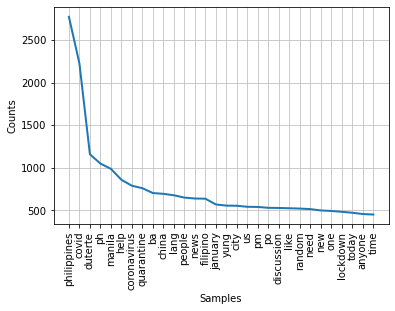

In [11]:
# plot of word frequency
print("total words: ", len(x_words))
fdist = FreqDist(x_words)
fdist.plot(30,cumulative=False)
plt.show()

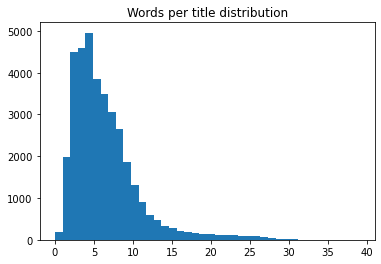

In [12]:
title_count = [len(each) for each in x_text]
plt.hist(title_count, bins = 40)
plt.title("Words per title distribution")
plt.show()

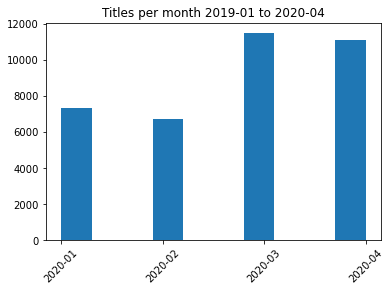

In [13]:
plt.hist(all_dates)
plt.title("Titles per month 2019-01 to 2020-04")
plt.xticks(rotation=45)
plt.show()

## Organizing the dataset 

Combine all the original and preprocessed data. Assign a unique identifier, **id**, on each title retrieved so that titles that topics retrieved later in LSA can be linked back to each reddit post title. Number of comments, score and over 18 were kept for exploration of data.

In [14]:
all_data = pd.DataFrame({
    'month' : all_dates,
    'Create Date' : all_creation,
    'orig_title' : all_titles,
    'clean_title' : x_corpus,
    'word_count' : title_count,
    'No. Comments' : all_comments,
    'Score': all_score,
    'Over 18' : all_18
})
all_data.index.name = 'id'
all_data = all_data.reset_index()
all_data.head()

,id,month,Create Date,orig_title,clean_title,word_count,No. Comments,Score,Over 18
0,0,2020-01,2020-01-01 00:56:58,telcoin - send money smarter,telcoin send money smarter,4,1,1,False
1,1,2020-01,2020-01-01 01:10:58,i just bought a small item from ebay and it's ...,bought small item ebay currently ems post offi...,13,3,2,False
2,2,2020-01,2020-01-01 01:18:06,did i give to much to my cousins while on vaca...,give much cousins vacation,4,0,1,False
3,3,2020-01,2020-01-01 01:29:22,"happy 2020, guys",happy guys,2,16,457,False
4,4,2020-01,2020-01-01 01:37:17,the kids today vs the kids of the past,kids today vs kids past,5,7,0,False


After cleaning up titles, some titles have become invalid where there are no remaining words. Such titles/rows will be removed those from being processed in subsequent steps.

In [15]:
print("All Data, rows: ", all_data.shape[0])
print("")
print(all_data.describe())
display(all_data[all_data['word_count']==0][0:5])
print("No. of Invalid Rows that will be deleted: ",
      all_data[all_data['word_count']==0].shape[0])

All Data, rows:  36623

                 id    word_count  No. Comments         Score
count  36623.000000  36623.000000  36623.000000  36623.000000
mean   18311.000000      6.112743     15.083008     33.956448
std    10572.293791      4.566834     75.477792    158.215968
min        0.000000      0.000000      0.000000      0.000000
25%     9155.500000      3.000000      0.000000      1.000000
50%    18311.000000      5.000000      3.000000      1.000000
75%    27466.500000      8.000000     11.000000     12.000000
max    36622.000000     39.000000   6331.000000   3904.000000


,id,month,Create Date,orig_title,clean_title,word_count,No. Comments,Score,Over 18
142,142,2020-01,2020-01-01 15:53:39,the 2010's,,0,23,45,False
220,220,2020-01,2020-01-02 04:32:07,😲,,0,1,1,False
971,971,2020-01,2020-01-05 16:04:36,⭐️,,0,2,1,False
1163,1163,2020-01,2020-01-06 14:02:41,:),,0,1,2,False
1292,1292,2020-01,2020-01-07 08:23:21,d i n g d o n g c a l t e x,,0,1,1,False


No. of Invalid Rows that will be deleted:  183


A new table ```titles``` will contain only the valid titles. We also keep here the field ```id``` to link back to original information in ```all_data```.

In [16]:
titles = all_data[all_data['word_count']>0].copy()
print("Remaining Valid Data, rows: ", titles.shape[0])
titles.head()

Remaining Valid Data, rows:  36440


,id,month,Create Date,orig_title,clean_title,word_count,No. Comments,Score,Over 18
0,0,2020-01,2020-01-01 00:56:58,telcoin - send money smarter,telcoin send money smarter,4,1,1,False
1,1,2020-01,2020-01-01 01:10:58,i just bought a small item from ebay and it's ...,bought small item ebay currently ems post offi...,13,3,2,False
2,2,2020-01,2020-01-01 01:18:06,did i give to much to my cousins while on vaca...,give much cousins vacation,4,0,1,False
3,3,2020-01,2020-01-01 01:29:22,"happy 2020, guys",happy guys,2,16,457,False
4,4,2020-01,2020-01-01 01:37:17,the kids today vs the kids of the past,kids today vs kids past,5,7,0,False


New and final corpus after all above cleaning steps completed.

In [17]:
new_corpus = titles['clean_title']
new_corpus.shape

(36440,)

## Dimensionality Reduction

To perform LSA, we need to vectorize our corpus. We use here TF-IDF:

In [18]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features= 50_000, # keep top 1000 terms, the higher the better
    max_df = 0.9, # remove words that appear in more than 90%
    min_df= 15,   # removing words that appear in less than X articles
    smooth_idf=True 
)

X = vectorizer.fit_transform(new_corpus)
print("After vectorizing the titles we have:")
print(f'Rows = {X.shape[0]} and Words = {X.shape[1]}')

After vectorizing the titles we have:
Rows = 36440 and Words = 2552


We then use our vectorized corpus in SVD:

In [19]:
# SVD represent documents and terms in vectors 
# n_components guidance: ideally #number of words-1
#                        compromise is to start with 500 & trial/error

n_comp = min(700, X.shape[1]-1)

svd_model = TruncatedSVD(n_components=n_comp, 
                         algorithm='randomized',
                         n_iter=100,
                         random_state=122)
lsa_data = svd_model.fit_transform(X)
print("done!")

done!


We represent some of the output in variables we will use later on to plot:

In [20]:
feature_names = vectorizer.get_feature_names()
Sigma = svd_model.singular_values_
V_T = svd_model.components_.T
nssd = svd_model.explained_variance_ratio_

Save the resulting model & transformed matrix to pickle file.

In [21]:
# BE CAREFUL!
# Modify to True if you want to run the extraction again
overwrite = False

# Extraction proper
if overwrite == True:

    fname_date = extract_fp[0].split('.')[0]

    # create new dictionary key per object
    json_all = dict()
    json_all['svd_model'] = svd_model
    json_all['lsa_data'] = lsa_data
    json_all['vectorizer'] = vectorizer
    json_all['titles'] = titles

    #for each source file, print number of json objects extracted
    print(f"File: {fname_date} saved")

    # Write into a pickle file
    # Uncomment if rewriting files.
    with open(f"./data_postprocessed/test_{fname_date}.pkl","wb") as file:
        pickle.dump(json_all, file)

    print('done!')

## Plotting Cumulative Variance

We want to ensure that we have 0.6 explained variance. We initially opted for a higher percentage as 90% but was only achievable if we drastically reduce our dataset, we determine the optimum SVs and illustrate this in a plot as well:

In [22]:
svs = np.array(nssd.cumsum())

# what is your ideal variance explained?
my_var = 0.6
my_svs = np.where(svs>= my_var)[0][0]
print("SV's to retain: ", my_svs)

SV's to retain:  654


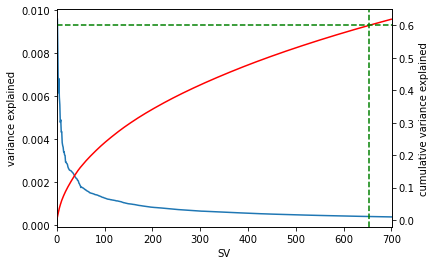

In [23]:
# using svd.explained_variance_ratio_
nssd = svd_model.explained_variance_ratio_

fig, ax = plt.subplots()
ax.plot(range(1, len(nssd)+1), nssd, '-', label='individual')
ax.set_xlim(0, len(nssd)+1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained')
ax = ax.twinx()
ax.plot(range(1, len(nssd)+1), nssd.cumsum(), 'r-', label='cumulative')
ax.axhline(my_var, ls='--', color='g')
ax.axvline(my_svs, ls='--', color='g')
ax.set_ylabel('cumulative variance explained');
